In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import f1_score
import re
import nltk
from wordcloud import WordCloud


In [2]:
df_tweet = pd.read_csv("Tweet.csv")

In [3]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [4]:
df_tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [5]:
df_company_tweet = pd.read_csv("Company_Tweet.csv")

In [6]:
df_company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [7]:
df_company_tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [8]:
tweets = pd.merge(df_company_tweet,df_tweet,on= "tweet_id", how = "inner")

In [9]:
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [10]:
def datasetInfo(dataset):
    print(f" Dataset Information and type \n {dataset.info()}")
    print("--------------------------------------------------------\n\n Data Types: ")
    print(dataset.dtypes)
    print("--------------------------------------------------------\n\n Rows and Columns: ")
    print(dataset.shape)
    print("--------------------------------------------------------\n\n Column Names: ")
    print(dataset.columns)
    print("--------------------------------------------------------\n\n Null Values: ")
    print(dataset.apply(lambda x: sum(x.isnull()) / len(dataset)))
    print("--------------------------------------------------------\n\n Unique Values: ")
    print(dataset.nunique())
    print("--------------------------------------------------------\n\n Describe: ")
    print(dataset.describe())

In [11]:
datasetInfo(tweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
dtypes: int64(5), object(3)
memory usage: 297.8+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id          int64
ticker_symbol    object
writer           object
post_date         int64
body             object
comment_num       int64
retweet_num       int64
like_num          int64
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(4336445, 8)
--------------------------------------------------------

 Column Names: 
Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num

After Merging Remove the dataframes that do not have ticker_symbols

In [12]:
tweets.dropna()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
...,...,...,...,...,...,...,...,...
4336440,1212158772015034369,TSLA,StockJoke,1577836146,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0
4336441,1212159099632267268,TSLA,sweetog76,1577836224,$TSLA Very Interesting dude:,0,0,0
4336442,1212159184931717120,TSLA,MelaynaLokosky,1577836245,If only 2020 brought more self-awareness to Te...,0,1,0
4336443,1212159838882533376,TSLA,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1


Convert our post_date time in seconds to date_time

In [13]:
tweets['post_date'] = pd.to_datetime(tweets["post_date"],utc = False , unit = 's',).dt.normalize()
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


We need our a training set and a testing set for the prediction of Neutral or Opinionated Tweets

In [14]:
tweets.sort_values(by = "comment_num" , ascending  = False, inplace = True)
tweets


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0
...,...,...,...,...,...,...,...,...
1496809,1063111486908690432,AAPL,OphirGottlieb,2018-11-15,https://cnbc.com/2018/11/15/cramer-mocks-idea-...,0,1,0
1496810,1063111625127923712,AAPL,DeItaOne,2018-11-15,"$AAPL AGGRESSIVELY HIRING 4G, 5G WIRELESS ENGI...",0,5,6
1496811,1063111748998258688,AAPL,naashonomics,2018-11-15,i can be brave now call it #StockMarket bottom...,0,0,1
1496812,1063111748998258688,AMZN,naashonomics,2018-11-15,i can be brave now call it #StockMarket bottom...,0,0,1


## First Find the sum of all the activities in the tweet post

In [15]:
tweets["tweet_activity"] = tweets["comment_num"] + tweets["like_num"] + tweets["retweet_num"]
tweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1496809,1063111486908690432,AAPL,OphirGottlieb,2018-11-15,https://cnbc.com/2018/11/15/cramer-mocks-idea-...,0,1,0,1
1496810,1063111625127923712,AAPL,DeItaOne,2018-11-15,"$AAPL AGGRESSIVELY HIRING 4G, 5G WIRELESS ENGI...",0,5,6,11
1496811,1063111748998258688,AAPL,naashonomics,2018-11-15,i can be brave now call it #StockMarket bottom...,0,0,1,1
1496812,1063111748998258688,AMZN,naashonomics,2018-11-15,i can be brave now call it #StockMarket bottom...,0,0,1,1


## Filter Tweets that are >= 100 activities

In [16]:
filterTweets = tweets.loc[tweets["tweet_activity"] > 100]

In [17]:
filterTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442


### Data Cleaning and Tokenization of text body

In [18]:

# filterTweets["body"].apply(lambda x : x.lower())

# # Remove stop_words from the list
# from nltk.corpus import stopwords
# stop_words =   stopwords.words('english')
# filterTweets['body'] = filterTweets['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub("'s","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub("'d"," had", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub(":","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub('``',"", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub(",","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub("'","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub("’","", x) )
# # Remove @ #Hashtags and links
# import re
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub(r"https\S+","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub(r"www.\S+","", x) )

# #Remove Punctuations
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub(r"[()!?]","", x) )
# filterTweets['body'] = filterTweets['body'].apply(lambda x: re.sub(r"\[.*?\']","", x) )





# # Separate body text into tokenised list
# filterTweets["body"].apply(lambda x : nltk.word_tokenize(x))



In [19]:
def clean_tweet(tweet):
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'d"," had", temp) 
    temp = re.sub("'s","", temp)
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub("’","", temp) 
    temp = re.sub("'","", temp)
    temp = re.sub(":","", temp)
    
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [20]:
filterTweets["body"].apply(lambda x : clean_tweet(x))
filterTweets["body"].apply(lambda x : nltk.word_tokenize(x))

3786974    [I, ’, d, just, like, to, point, out, that, ri...
4112626    [If, a, Tesla, saves, you, $, 200, a, month, o...
4306536    [~Tesla, feature, request, thread~Feel, free, ...
2823018    [``, I, sell, books, ., '', versus, ``, I, sel...
4182686    [“, I, think, it, 's, basically, financially, ...
                                 ...                        
1493830    [11/13/18, -, View, today, 's, #, MarketOutloo...
1493831    [11/13/18, -, View, today, 's, #, MarketOutloo...
1498488    [Watch, Us, Report, LIVE, from, the, Floor, of...
1498489    [Watch, Us, Report, LIVE, from, the, Floor, of...
1498490    [Watch, Us, Report, LIVE, from, the, Floor, of...
Name: body, Length: 17366, dtype: object

In [21]:
filterTweets["body"].head()

3786974    I’d just like to point out that right now, rig...
4112626    If a Tesla saves you $200 a month on gas, you ...
4306536    ~Tesla feature request thread~Feel free to rep...
2823018    "I sell books." versus "I sell whatever the fu...
4182686    “I think it's basically financially insane to ...
Name: body, dtype: object

### Tweet EDA

In [22]:
filterTweets["writer"].describe()


count               17269
unique               1630
top       vincent13031925
freq                 1252
Name: writer, dtype: object

### Writer Data Exploration

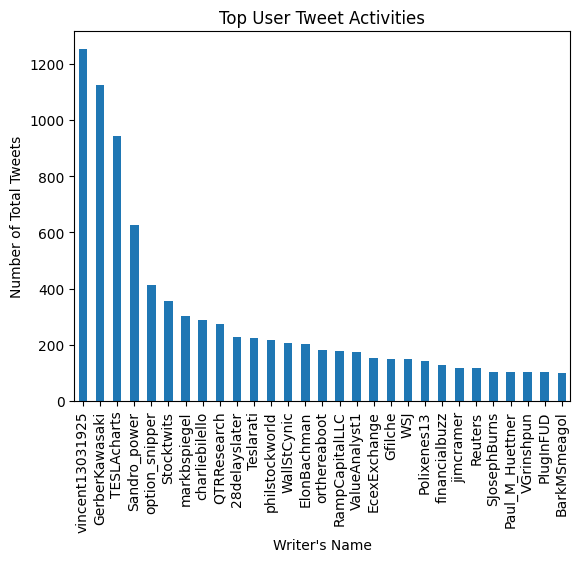

In [23]:

counts = filterTweets["writer"].value_counts()
countsFilter = counts[counts > 100]
countsFilter.plot(kind="bar")
plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("Writer's Name")
plt.show()

Graph above shows the top writers that are active and have >100 posts

<AxesSubplot: ylabel='ticker_symbol'>

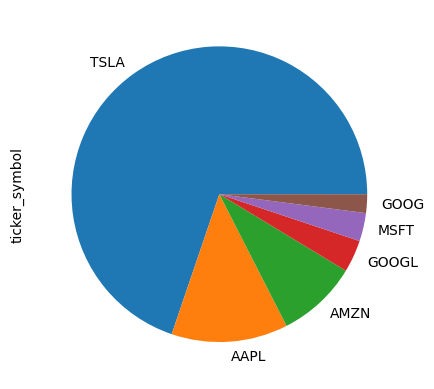

In [24]:

counts = filterTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

Notice that there are more TSLA tweets in the dataset.

### Active Tweets dates

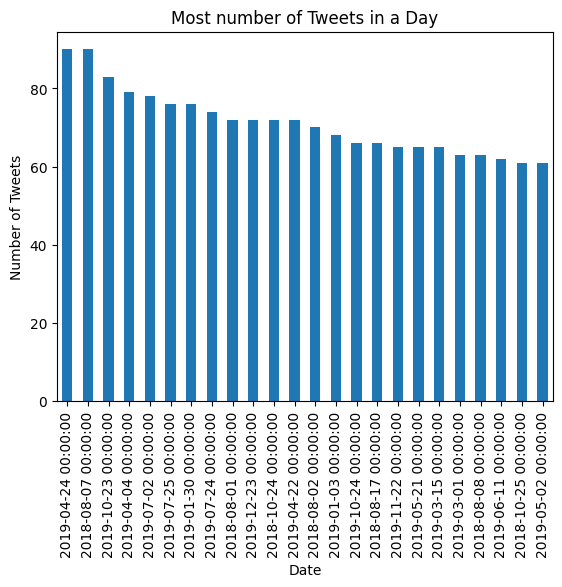

In [25]:
count = filterTweets["post_date"].value_counts()
count
filterCounts = count[count > 60]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

Above bar graphs shows the highest tweets in the respective days

### Word Cloud of Tweets

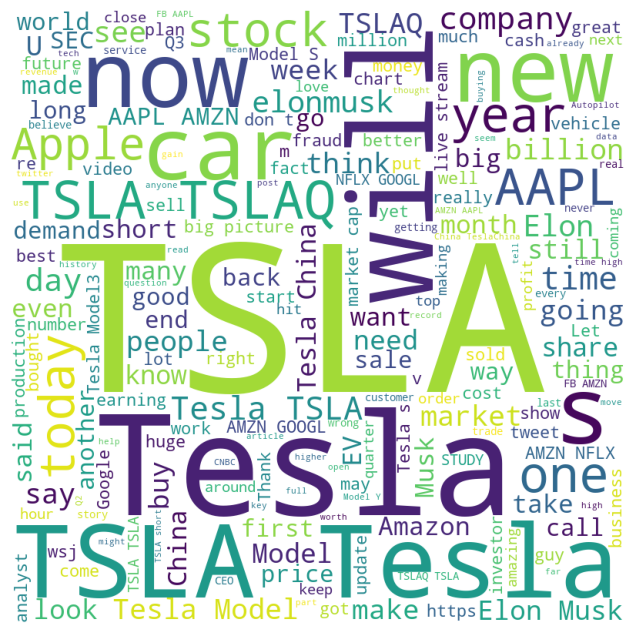

In [26]:
text = " ".join(filterTweets["body"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud we can tell that TSLA/TESLA and AAPL are common tweets in Twitter

# Polarity Detection

### Import Sentiment Analyser from NLTK

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [28]:
analyser = SentimentIntensityAnalyzer()

In [29]:
def getSentiment(body):
    analyser = SentimentIntensityAnalyzer()
    
    assert body is not None
    sentimentAnalysis = analyser.polarity_scores(body)
    score = sentimentAnalysis['compound']
    
    if (score >= 0.05):
        return "Positive"
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    elif (score <= -0.05):
        return "Negative"
    
    print(score)
    

In [30]:
filterTweets['Sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))

filterTweets


C:\Users\eric2\AppData\Local\Temp\ipykernel_30160\2876228253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets['Sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,Sentiment
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000,Positive
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567,Neutral
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273,Positive
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496,Negative
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442,Positive
...,...,...,...,...,...,...,...,...,...,...
1493830,1062474276559699968,AAPL,BrandonVanZee,2018-11-13,11/13/18 - View today's #MarketOutlook from @M...,0,32,120,152,Neutral
1493831,1062474276559699968,AMZN,BrandonVanZee,2018-11-13,11/13/18 - View today's #MarketOutlook from @M...,0,32,120,152,Neutral
1498488,1063566557677146112,AAPL,financialbuzz,2018-11-16,Watch Us Report LIVE from the Floor of the NYS...,0,126,80,206,Neutral
1498489,1063566683720175616,AAPL,financialbuzz,2018-11-16,Watch Us Report LIVE from the Floor of the NYS...,0,86,62,148,Neutral


### Convert Positive, Negative and Neutral to numeral labels

In [31]:
sentiment_map = {"Positive": 1, "Negative": 0, "Neutral": 2}

In [32]:
filterTweets["Sentiment"].replace(sentiment_map, inplace = True)

C:\Users\eric2\AppData\Local\Temp\ipykernel_30160\3637403301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["Sentiment"].replace(sentiment_map, inplace = True)


### Splitting up data for Prediction using ensemble machine learning models

In [33]:
X = filterTweets["body"] #["ticker_symbol","writer" , "body"]
y = filterTweets["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=0)

In [34]:
X_train.info()
X_train.head()

<class 'pandas.core.series.Series'>
Int64Index: 16497 entries, 3688104 to 4156026
Series name: body
Non-Null Count  Dtype 
--------------  ----- 
16497 non-null  object
dtypes: object(1)
memory usage: 257.8+ KB


3688104    Tesla stock $TSLA crosses 3-month high as Mode...
3980319    No one will make a better electric car than Te...
4200832    BMW CEO resigns and there is silence in the me...
4044101    Tesla Model 3 is now officially deliver in Chi...
4295399    Video taken at parcel of land where #Tesla #Gi...
Name: body, dtype: object

In [35]:
X_test.info()
X_test.head()

<class 'pandas.core.series.Series'>
Int64Index: 869 entries, 3719865 to 3772997
Series name: body
Non-Null Count  Dtype 
--------------  ----- 
869 non-null    object
dtypes: object(1)
memory usage: 13.6+ KB


3719865       The new Tesla Model Y looks pretty good. $TSLA
3714777    Tesla $TSLA delivered 29,980 vehicles in Q1, M...
3837024    This looks like a pretty relaxed guy for someo...
3872840    1/ I started this account after years of lurki...
2935213    JUST another great wining plan in $AMZN with m...
Name: body, dtype: object

In [36]:
y_train.info()
y_train.head()

<class 'pandas.core.series.Series'>
Int64Index: 16497 entries, 3688104 to 4156026
Series name: Sentiment
Non-Null Count  Dtype
--------------  -----
16497 non-null  int64
dtypes: int64(1)
memory usage: 257.8 KB


3688104    2
3980319    1
4200832    0
4044101    1
4295399    2
Name: Sentiment, dtype: int64

In [37]:
y_test.info()
y_test.head()


<class 'pandas.core.series.Series'>
Int64Index: 869 entries, 3719865 to 3772997
Series name: Sentiment
Non-Null Count  Dtype
--------------  -----
869 non-null    int64
dtypes: int64(1)
memory usage: 13.6 KB


3719865    1
3714777    1
3837024    1
3872840    1
2935213    1
Name: Sentiment, dtype: int64

In [38]:
filterTweets["Sentiment"].value_counts()

1    7834
2    5220
0    4312
Name: Sentiment, dtype: int64


### Separating Neutral Sentiments and Opinionated Sentiments

In [39]:
opinionatedTweets = filterTweets.loc[filterTweets["Sentiment"]!= 2]
opinionatedTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,Sentiment
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000,1
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442,1
3003947,1083042743293747200,AMZN,fillbeforeshill,2019-01-09,Jeff Bezos' wife is a better investor than all...,387,0,0,387,1


In [40]:
neutralTweets = filterTweets.loc[filterTweets["Sentiment"] == 2]
neutralTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,Sentiment
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567,2
1473043,1056163287992274945,AAPL,eWhispers,2018-10-27,#earnings for the week$FB $AAPL $BABA $GE $IQ ...,348,260,354,962,2
4002464,1082182633948295168,TSLA,vincent13031925,2019-01-07,Tesla CEO @elonmusk with Shanghai Mayor Ying Y...,318,0,0,318,2
4301361,1197894016358060032,TSLA,carlquintanilla,2019-11-22,"Caption, please.$TSLA #Cybertruck(via @TeflonG...",276,27,201,504,2
4244910,1172211592848527360,TSLA,edmunds,2019-09-12,cultural impact: █ ...,218,63,459,740,2


### Create a Naive_bayes Model

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [42]:
vectoriser = CountVectorizer()

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Make predictions on test data
y_pred = clf.predict(X_test_vec)

# Evaluate the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
Fscore = f1_score(y_test,y_pred,average = "weighted")
print("Accuracy:", accuracy)
print("Fscore:" , Fscore)

Accuracy: 0.6547756041426928
Fscore: 0.6456624458847938


### Create a Decision Tree Classifier

In [43]:
clf = DecisionTreeClassifier()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)

accuracy = accuracy_score(y_test,y_pred)
Fscore = f1_score(y_test,y_pred,average = "weighted")
print("Accuracy: {:.2f}".format(accuracy))
print("Fscore:" , Fscore)


Accuracy: 0.63
Fscore: 0.6281415917683575


### Create a Ensemble Learning Classifier


In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [45]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_vec)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
Fscore = f1_score(y_test,y_pred,average = "weighted")
print("Accuracy: {:.2f}".format(accuracy))
print("Fscore:" , Fscore)

Accuracy: 0.72
Fscore: 0.7055134823017245


### Support Vector Machine Models


In [46]:
from sklearn import svm
clf = svm.SVC(kernel = "rbf",random_state = 1)
clf.fit(X_train_vec,y_train)

SVC(random_state=1)

In [47]:
svm_pred = clf.predict(X_test_vec)
print(svm_pred)

[1 2 1 1 1 2 0 1 1 0 2 1 2 1 2 1 1 2 2 2 2 2 2 0 0 1 0 1 1 1 0 2 1 0 2 2 1
 1 2 1 1 1 2 1 1 2 1 2 1 1 0 1 0 2 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1
 2 0 1 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 1 2 2 2 2 1 2 0 2 0 1
 1 2 2 2 2 0 1 1 1 2 1 1 0 0 1 2 2 2 1 1 1 2 0 1 0 0 1 2 2 1 0 1 1 1 1 2 1
 2 1 1 2 0 0 1 1 2 2 1 2 1 2 1 1 1 1 1 2 1 1 1 0 2 1 2 2 2 1 2 1 2 1 2 2 2
 2 0 1 2 1 2 2 1 0 1 1 2 1 0 1 1 1 0 1 1 1 1 0 0 2 2 2 1 1 1 1 1 1 1 2 2 2
 2 1 2 2 2 1 2 2 1 1 2 1 1 0 2 1 1 1 2 2 0 1 0 1 2 1 1 0 2 1 1 1 1 2 1 0 1
 1 1 2 2 1 1 1 2 2 1 2 1 2 2 2 2 1 1 0 1 1 1 2 2 2 2 2 0 2 2 2 2 1 1 1 2 1
 1 2 0 2 0 2 0 1 1 2 2 2 1 1 2 1 2 0 2 1 2 2 1 1 2 2 1 0 1 0 1 1 2 2 1 1 1
 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 0 0 1 1 1 0 0 0 1 2 1 2 1 1 0 1 1 1 0 0 0 1
 1 2 1 1 2 1 0 2 1 0 1 0 1 1 2 1 1 1 1 1 0 0 2 2 1 2 2 2 1 2 0 2 2 1 2 2 1
 0 0 1 1 1 1 0 1 2 2 1 2 2 1 1 0 0 2 1 1 0 1 1 2 1 2 1 1 1 0 2 2 1 2 0 2 1
 1 2 0 1 1 0 2 1 0 2 1 1 1 1 2 2 2 1 1 1 1 0 1 0 2 2 1 1 0 0 1 0 2 2 2 0 1
 1 2 1 1 1 1 1 1 1 1 1 1 

In [48]:
svmAccuracy = accuracy_score(y_test,svm_pred)
svmFscore = f1_score(y_test,svm_pred,average = "weighted")
print(f"The accuracy of Support Vector Machines is {svmAccuracy}")
print(f"The F score of Support Vector Machines is {svmFscore}")

The accuracy of Support Vector Machines is 0.7307249712313003
The F score of Support Vector Machines is 0.7238219148002503


### K-Nearest Neighbour Classification

In [49]:

from sklearn.neighbors import KNeighborsClassifier

#Finding the optimal k from 1-30
kRange = range(1,31)

scores = []

for kValue in kRange:
    knnClass = KNeighborsClassifier(n_neighbors = kValue)
    knnClass.fit(X_train_vec,y_train)
    knn_pred= knnClass.predict(X_test_vec)
    scores.append(accuracy_score(y_test,knn_pred))
    
maxKAccuracy = 0
maxKValue = 0

for i, x in enumerate(scores):
    if i == 0:
        maxKAccuracy = x
        maxKValue = i+1
    if x > maxKAccuracy:
        maxKAccuracy = x
        maxKValue = i+1

print(f"K value : {maxKValue} \nAccuracy : {maxKAccuracy}")

K value : 2 
Accuracy : 0.5281933256616801


In [50]:
knnClass = KNeighborsClassifier(n_neighbors = maxKValue)
knnClass.fit(X_train_vec,y_train)

KNeighborsClassifier(n_neighbors=2)

In [51]:
knnPredicted = knnClass.predict(X_test_vec)
print(knnPredicted)

[1 2 2 2 1 2 0 1 2 2 2 1 2 2 2 2 1 1 2 1 2 2 1 1 1 1 1 0 2 2 2 1 2 0 2 2 2
 1 1 1 2 2 2 2 1 2 0 1 0 1 0 0 0 1 1 2 2 1 1 0 1 0 1 2 1 0 0 0 2 2 1 0 2 2
 2 2 2 0 1 1 2 2 1 1 1 1 1 1 1 2 1 2 1 1 2 1 0 1 1 0 1 1 2 2 2 0 1 0 2 1 1
 0 2 2 1 2 0 1 1 1 1 2 2 0 0 1 2 2 1 1 2 1 1 0 2 2 0 2 2 2 1 0 1 1 2 1 1 1
 2 2 1 1 1 0 2 1 2 2 0 0 1 2 2 1 1 0 0 1 2 1 2 2 0 1 2 2 2 2 2 2 2 1 2 0 2
 1 0 1 2 1 2 1 2 0 0 1 1 1 0 2 1 1 2 1 2 2 0 0 1 2 2 2 2 2 1 2 1 1 1 1 1 2
 2 2 1 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 0 0 0 2 1 2 1 1 0 1 2 2 0 1 2 1 2 1
 2 2 2 1 0 2 1 2 1 1 2 2 2 1 2 2 2 2 2 1 2 1 1 2 1 2 2 2 1 1 2 1 2 1 1 2 1
 2 2 0 2 1 2 2 2 2 1 2 2 0 1 1 1 2 0 2 2 1 1 1 1 1 1 1 2 1 0 1 1 1 2 2 2 1
 2 1 0 2 2 2 1 1 2 0 2 2 2 2 1 1 0 1 0 1 2 2 2 1 1 1 2 0 1 2 1 2 1 1 2 0 1
 1 2 0 1 2 1 2 2 2 2 1 1 2 1 2 1 1 2 1 1 0 0 2 2 1 2 2 2 2 1 2 1 2 2 2 1 1
 0 0 1 1 0 0 0 0 2 2 2 0 2 1 1 2 2 2 2 1 1 2 2 2 2 2 1 1 1 0 1 2 0 2 2 2 2
 1 2 0 2 2 1 2 0 0 1 2 0 1 2 2 2 2 0 2 2 1 0 1 0 1 2 1 2 0 0 1 1 2 2 2 2 1
 1 0 0 1 1 1 1 1 2 2 1 2 

In [52]:
knnAccuracy = accuracy_score(y_test,knnPredicted)
knnFscore = f1_score(y_test,knnPredicted,average = "weighted")
print(f"The accuracy of K-Nearest-Neighbour is {knnAccuracy}")
print(f"The F score of K-Nearest-Neighbour is {knnFscore}")

The accuracy of K-Nearest-Neighbour is 0.5281933256616801
The F score of K-Nearest-Neighbour is 0.5258085802236429


In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,knnPredicted)
cm

array([[ 79,  68,  89],
       [ 56, 230, 115],
       [ 25,  57, 150]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

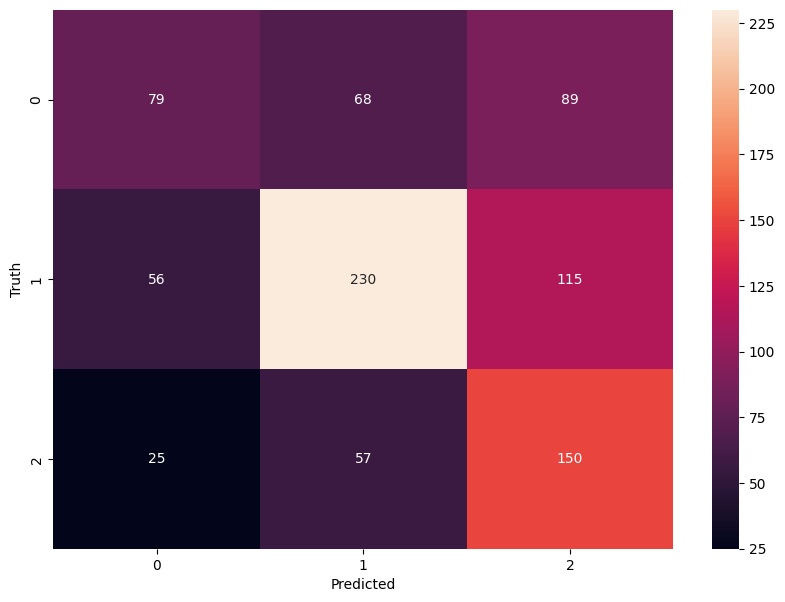

In [54]:
%matplotlib inline
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "d")
plt.xlabel("Predicted")
plt.ylabel("Truth")

### Neural Network

In [55]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_vec,y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(128,), max_iter=1000,
              random_state=1, solver='lbfgs')

In [56]:
nn_pred = clf.predict(X_test_vec)
print(nn_pred)

[1 2 1 1 1 2 0 1 1 1 2 1 2 0 0 2 1 2 0 2 2 2 2 0 0 1 0 0 1 0 0 2 2 0 2 2 0
 1 2 1 1 1 2 1 0 2 2 1 1 1 0 1 0 2 1 1 0 1 1 0 1 0 1 0 0 1 1 2 0 1 1 1 1 2
 0 0 0 0 1 1 1 2 1 1 1 1 1 1 1 2 0 1 2 1 0 1 1 1 1 2 1 2 2 2 2 0 2 2 1 1 1
 1 0 2 2 2 0 1 0 1 2 1 2 0 0 2 2 2 2 1 1 1 1 0 1 0 0 1 2 2 1 0 1 1 2 1 2 1
 2 1 1 2 0 0 1 1 2 2 0 1 0 2 1 1 1 0 1 2 0 0 1 0 0 1 2 2 0 1 2 1 2 1 2 2 2
 2 0 1 2 1 2 2 1 0 1 0 2 0 0 2 1 1 1 1 1 1 1 0 0 2 2 2 1 0 1 1 1 0 1 0 1 2
 0 1 2 2 2 1 2 2 1 2 0 1 1 0 2 0 2 1 2 2 1 0 0 1 1 1 1 0 2 1 1 0 1 2 0 1 1
 2 1 1 1 1 2 1 2 2 1 2 1 2 1 2 2 1 1 0 1 2 1 1 2 2 1 0 0 1 0 2 1 1 1 1 2 1
 1 2 0 2 1 2 0 0 1 2 2 2 1 1 1 1 2 2 2 1 1 2 1 1 1 2 1 0 1 0 1 1 1 2 1 1 1
 2 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 2 0 1 2 0 2 0 1 0 1 2 1 1 0 0 1
 1 2 1 1 2 1 0 2 1 0 1 0 1 1 2 1 1 1 1 1 0 0 2 2 1 2 2 2 1 2 0 1 2 1 2 2 1
 0 0 1 1 1 1 0 1 2 2 1 2 2 2 1 0 0 0 1 0 0 2 1 2 1 2 1 1 1 0 1 2 1 2 0 2 1
 0 2 1 1 0 0 2 1 0 2 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 2 2 1 1
 1 2 1 1 2 1 1 1 1 2 1 1 

In [57]:
nnAccuracy = accuracy_score(y_test,nn_pred)
nnFscore = f1_score(y_test,nn_pred,average = "weighted")
print(f"The accuracy of Neutral Network is {nnAccuracy}")
print(f"The F score of Neural Network is {nnFscore}")

The accuracy of Neutral Network is 0.7917146144994246
The F score of Neural Network is 0.7902192930830941
